In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import tensorflow as tf
import numpy as np
import os.path as osp

from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d

from tf_lab.point_clouds.encoders_decoders import decoder_with_fc_only
from tf_lab.external.structural_pc_losses import losses
from general_tools.notebook.tf import reset_tf_graph
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from geo_tool import Point_Cloud

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

In [3]:
import helper

from tf_lab.diff_maps.in_out import raw_data, produce_net_data,\
prep_splits_labels_for_task, produce_diff_maps, classes_of_tasks

from tf_lab.diff_maps.basic_nets import pc_net, diff_mlp_net, diff_conv_net, pc_versions
from tf_lab.diff_maps.basic_nets import Basic_Net

In [4]:
from numpy.linalg import inv

In [5]:
from general_tools.clustering.convenience import find_nearest_neighbors
from general_tools.in_out import create_dir

In [6]:
%matplotlib inline

In [7]:
top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses/'
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses'
gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
n_pose_classes = helper.n_pose_classes

In [165]:
use_pc = False
knn = 0
arch = 'conv'
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 4096
mean_norm_diffs = True
n_cons = 40
seed = 42
synced_bases_file = osp.join(top_data_dir, '50_extract_%d_knn_50_fmapd.mat' % (knn,) )

top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses/reconstructions'
create_dir(top_out_dir);

In [166]:
gt_latent_params, in_pcs, pose_labels = \
raw_data(top_mesh_dir, gt_param_f, sub_member_per_class, n_pc_points)
diff_maps = produce_diff_maps(synced_bases_file, n_cons, n_shapes)
np.random.seed(seed)
r_perm = np.random.permutation(np.arange(n_shapes))
in_pcs = in_pcs[r_perm]
diff_maps = diff_maps[r_perm]

In [167]:
if not use_pc:
    net_data = dict()
    net_data['train'] = NumpyDataset([diff_maps[:300], in_pcs[:300]])
    net_data['test'] = NumpyDataset([diff_maps[300:360], in_pcs[300:360]])
    net_data['val'] = NumpyDataset([diff_maps[360:], in_pcs[360:]])
else:
    from tf_lab.point_clouds.in_out import PointCloudDataSet
    net_data = dict()
    net_data['train'] = PointCloudDataSet(in_pcs[:300])
    net_data['test'] = PointCloudDataSet(in_pcs[300:360])
    net_data['val'] = PointCloudDataSet(in_pcs[360:])

pc_analogies = in_pcs[300:]
feed_analogies = diff_maps[300:]
all_train_maps = diff_maps[:300]
all_train_pcs = in_pcs[:300]

In [148]:
reset_tf_graph()
tf.set_random_seed(seed)

batch_size = 50
learning_rate = 0.005
nn_distance, approx_match, match_cost = losses()
def diff_reconstructor(n_cons, n_pc_points):
    'Optimized for n_cons = 40'
    with tf.variable_scope('conv_based_reconstructor'):
        feed_pl = tf.placeholder(tf.float32, shape=(None, n_cons, n_cons))
        labels_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
        layer = tf.expand_dims(feed_pl, -1)
        layer = conv_2d(layer, nb_filter=20, filter_size=3, strides=2, activation='relu')
        layer = conv_2d(layer, nb_filter=20, filter_size=6, strides=2, activation='relu')
        net_out = decoder_with_fc_only(layer, layer_sizes=[128, 128, n_pc_points*3], b_norm=False)
        net_out = tf.reshape(net_out, [-1, n_pc_points, 3])
    return net_out, feed_pl, labels_pl

reset_tf_graph()
x_reconstr, feed_pl, labels_pl = diff_reconstructor(n_cons, n_pc_points)


match = approx_match(x_reconstr, labels_pl)
loss = tf.reduce_mean(match_cost(x_reconstr, labels_pl, match))

# cost_p1_p2, _, cost_p2_p1, _ = nn_distance(x_reconstr, labels_pl)
# loss = tf.reduce_mean(cost_p1_p2) + tf.reduce_mean(cost_p2_p1)


optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

g = tf.get_default_graph()
latent_coder = g.get_tensor_by_name('conv_based_reconstructor/Relu:0')


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
init = tf.global_variables_initializer()
sess = tf.Session(config=config)
sess.run(init)

In [150]:
max_epochs = 200
batches_for_epoch = net_data['train'].n_examples / batch_size
n_plot = 20
for epoch in xrange(max_epochs):
    epoch_loss = 0.0
    for _ in xrange(batches_for_epoch):
        feed, gt = net_data['train'].next_batch(batch_size)
        feed_dict = {feed_pl:feed, labels_pl:gt}
        _, l = sess.run([train_step, loss], feed_dict)
        epoch_loss += l
    if epoch % n_plot == 0:        
        print epoch, epoch_loss / float(batches_for_epoch),
        
        feed, gt = net_data['val'].next_batch(net_data['val'].n_examples)
        feed_dict = {feed_pl:feed, labels_pl:gt}
        l = sess.run(loss, feed_dict)
        print l

0 178.069697062 198.834
20 174.441624959 199.501
40 172.735575358 196.135
60 172.746370951 199.345
80 173.232284546 198.781
100 174.425394694 196.017
120 172.257527669 197.172
140 171.668070475 205.183
160 173.530339559 200.196
180 171.909317017 199.942


0


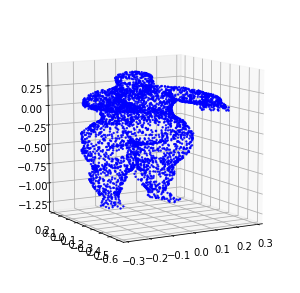

1


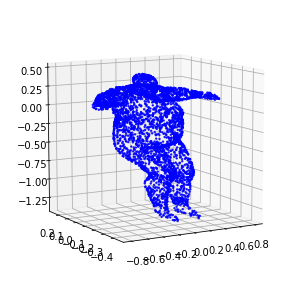

2


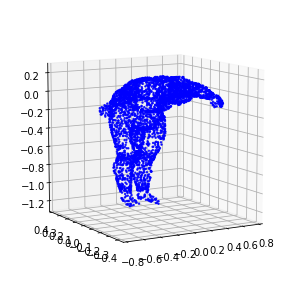

3


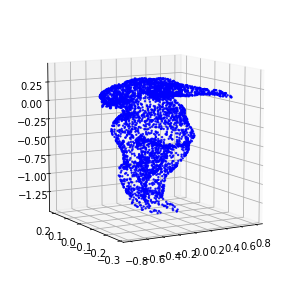

4


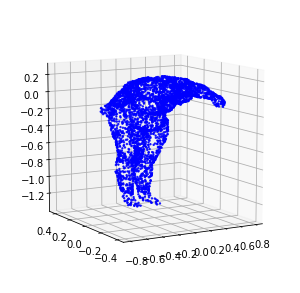

5


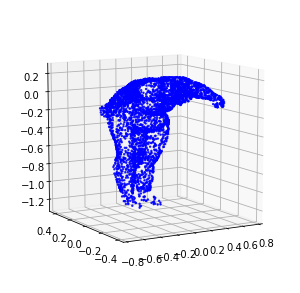

6


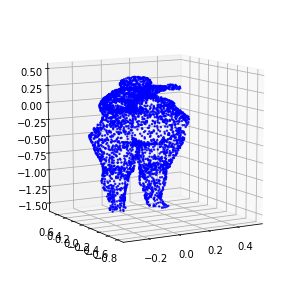

7


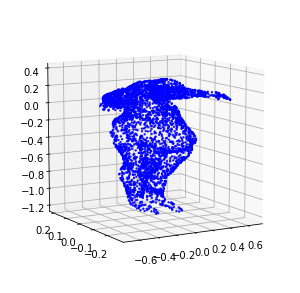

8


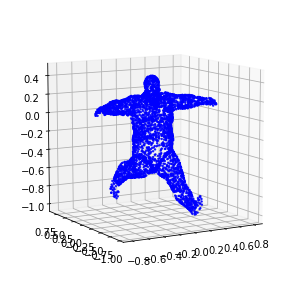

9


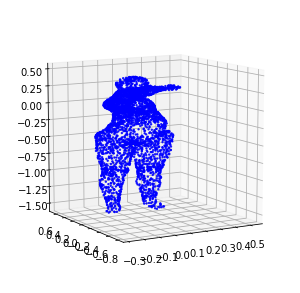

10


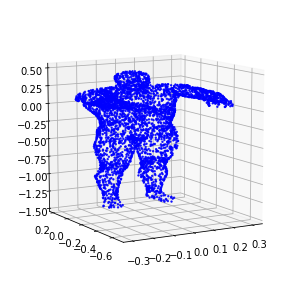

11


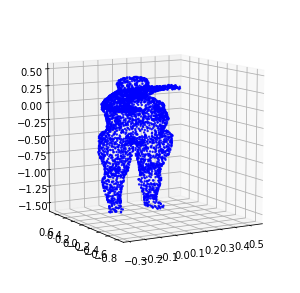

12


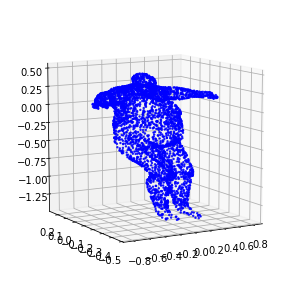

13


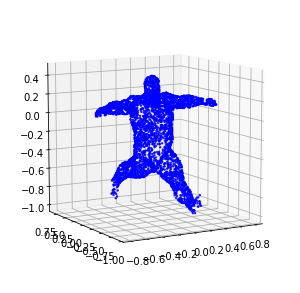

14


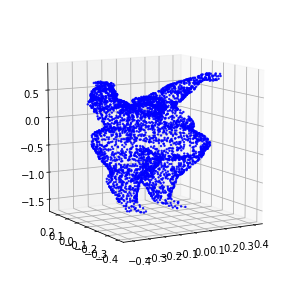

15


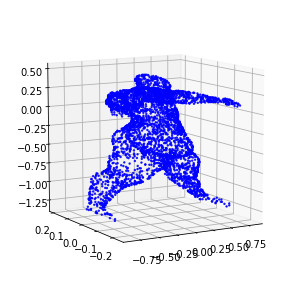

16


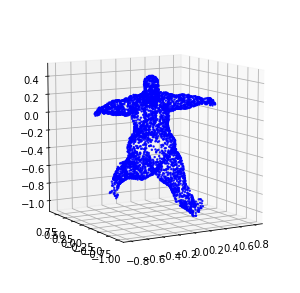

17


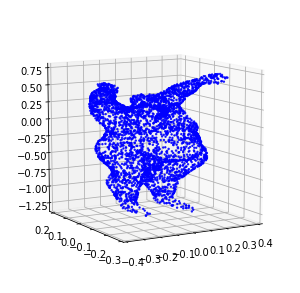

18


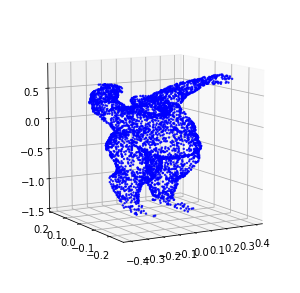

19


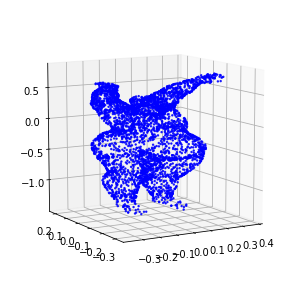

20


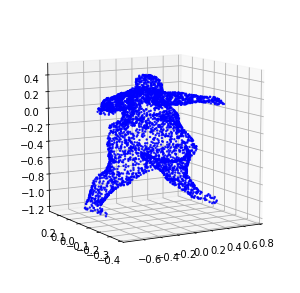

21


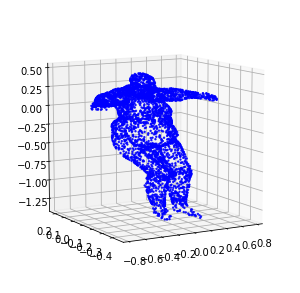

22


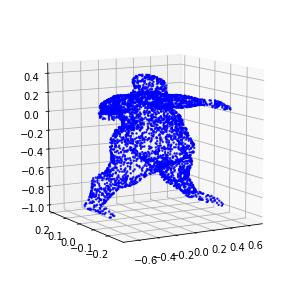

23


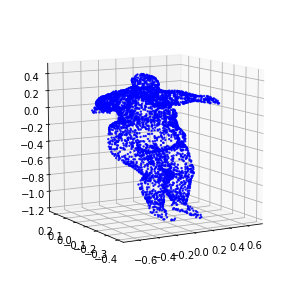

24


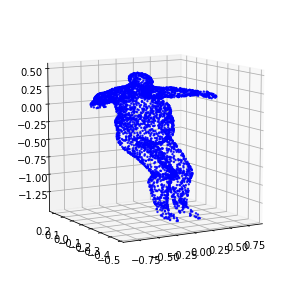

25


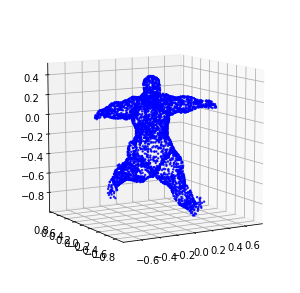

26


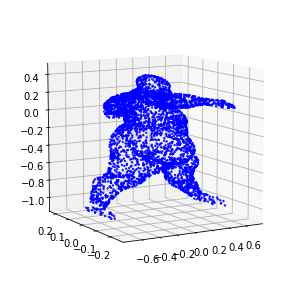

27


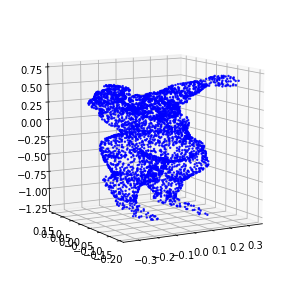

28


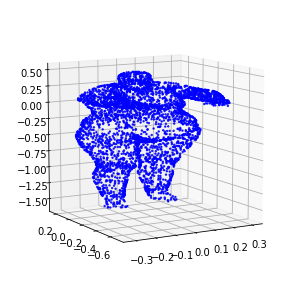

29


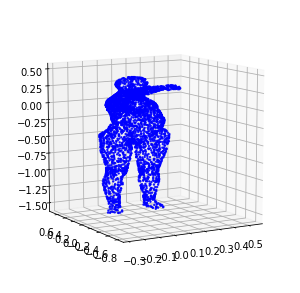

30


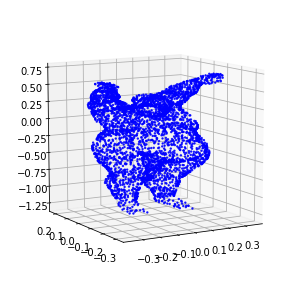

31


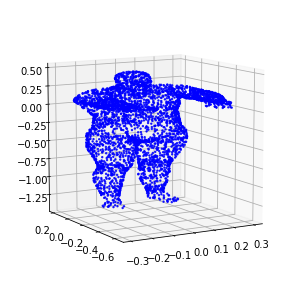

32


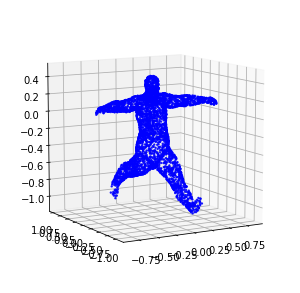

33


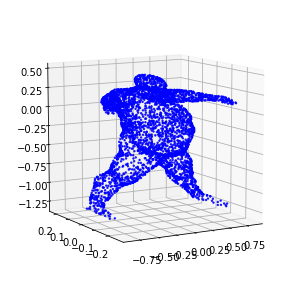

34


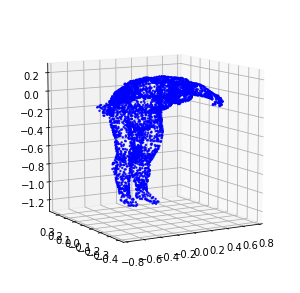

35


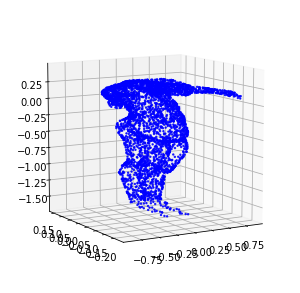

36


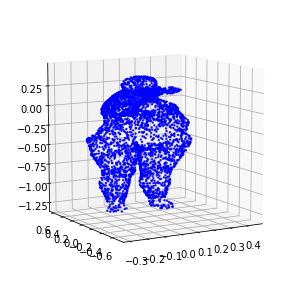

37


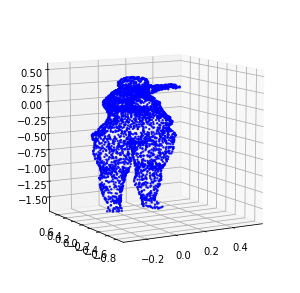

38


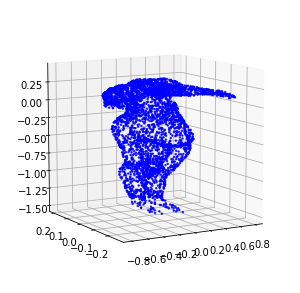

39


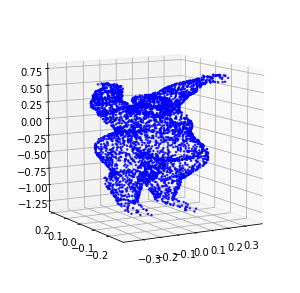

40


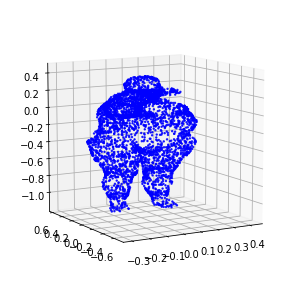

41


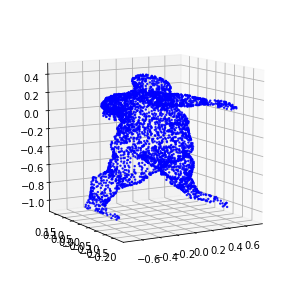

42


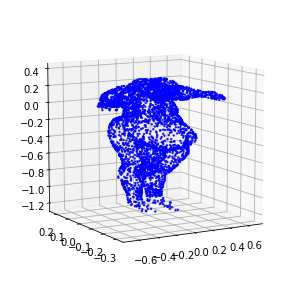

43


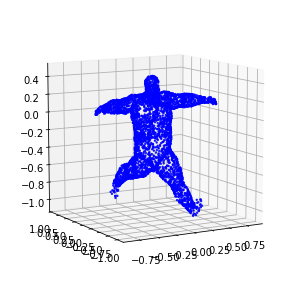

44


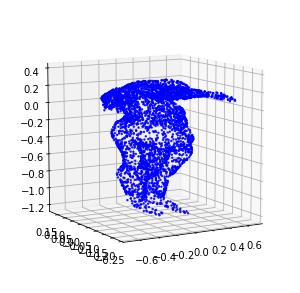

45


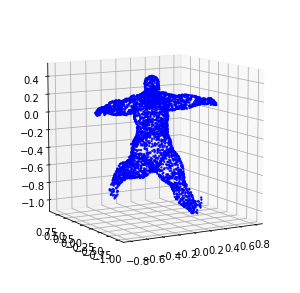

46


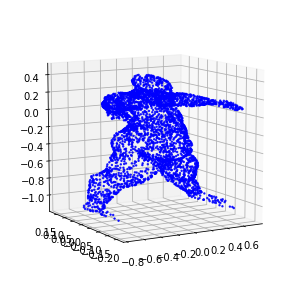

47


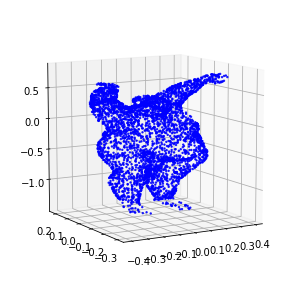

48


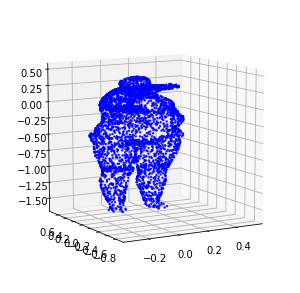

49


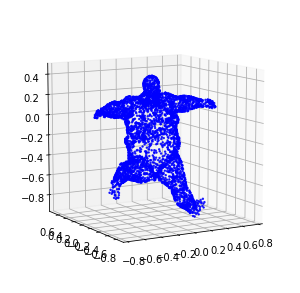

50


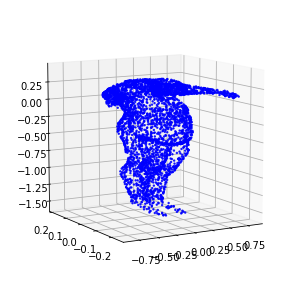

51


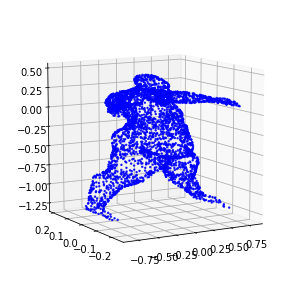

52


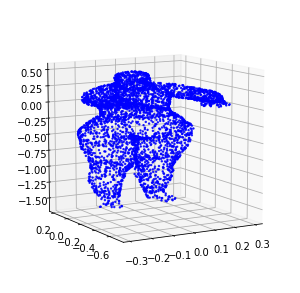

53


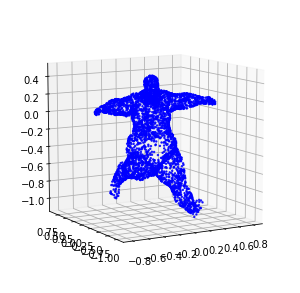

54


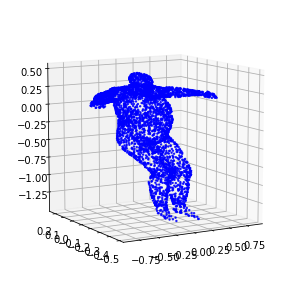

55


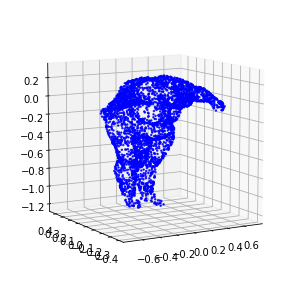

56


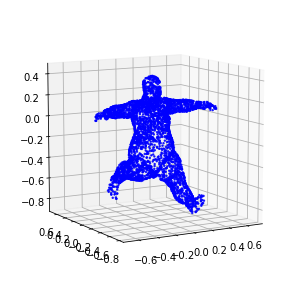

57


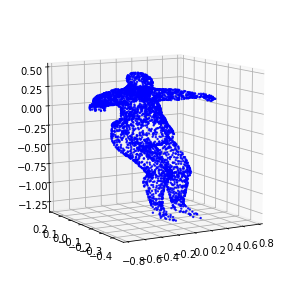

58


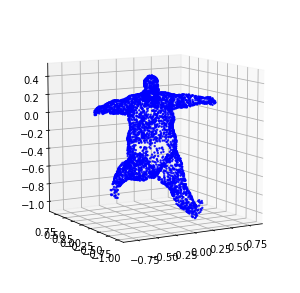

59


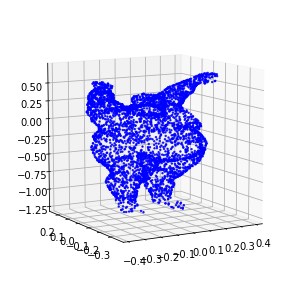

60


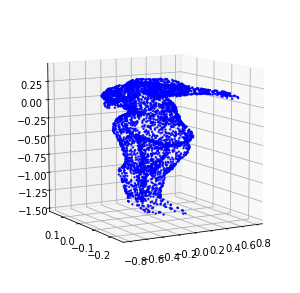

61


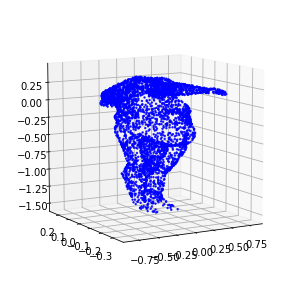

62


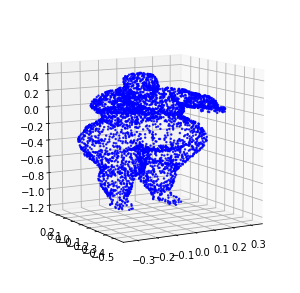

63


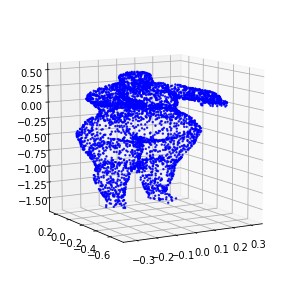

64


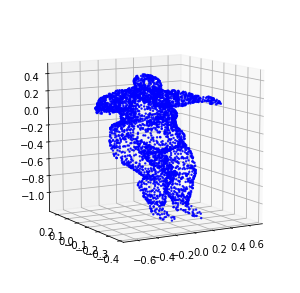

65


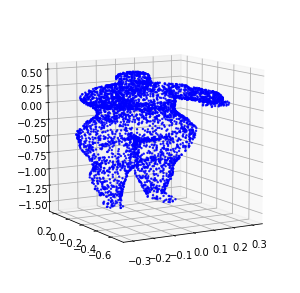

66


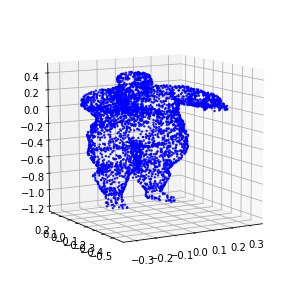

67


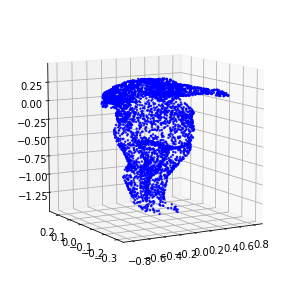

68


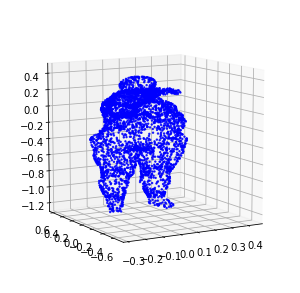

69


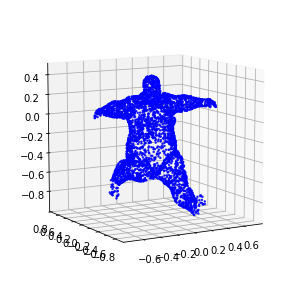

70


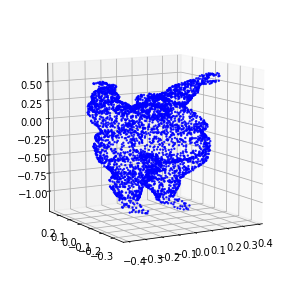

71


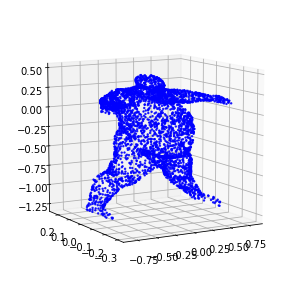

72


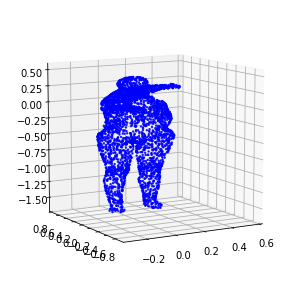

73


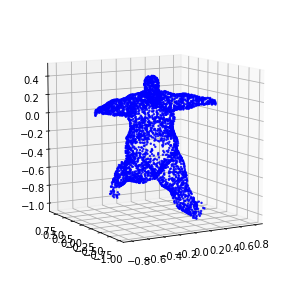

74


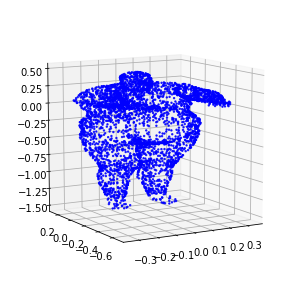

75


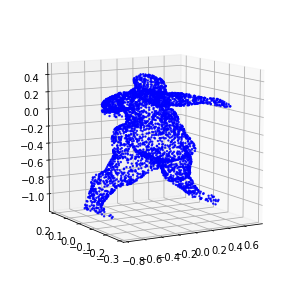

76


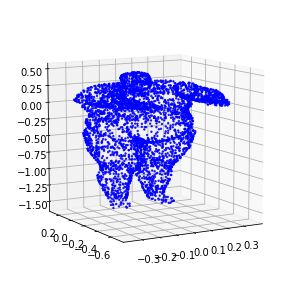

77


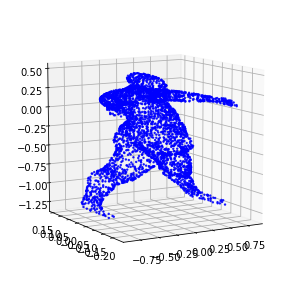

78


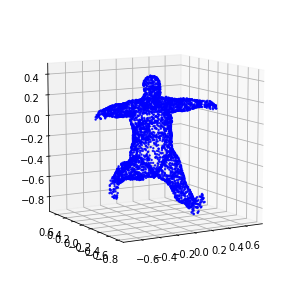

79


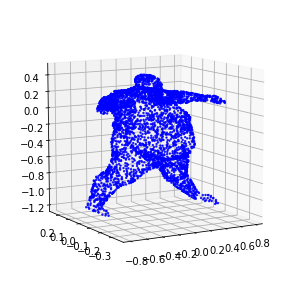

80


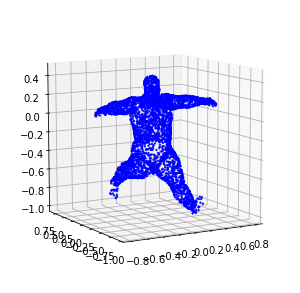

81


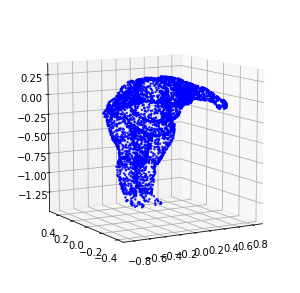

82


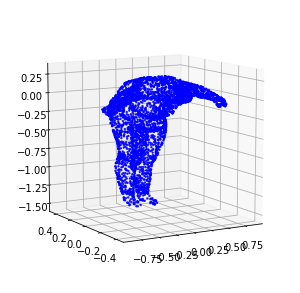

83


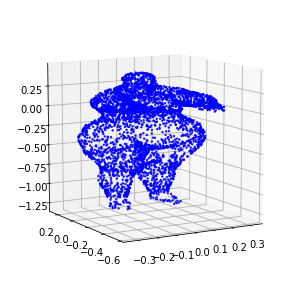

84


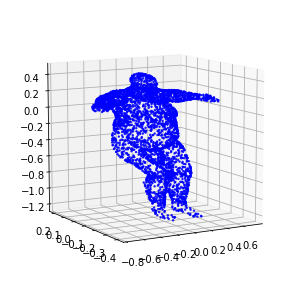

85


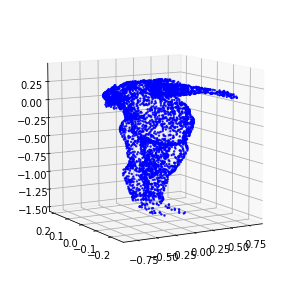

86


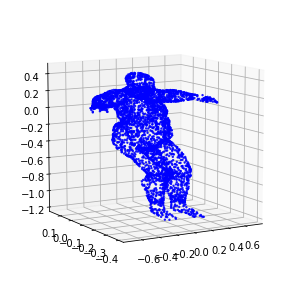

87


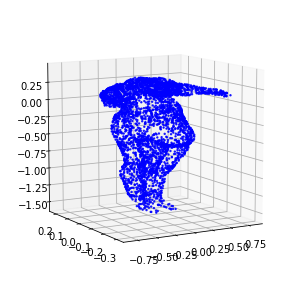

88


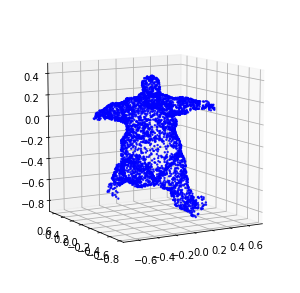

89


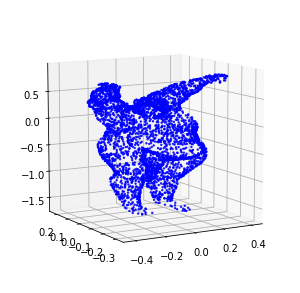

90


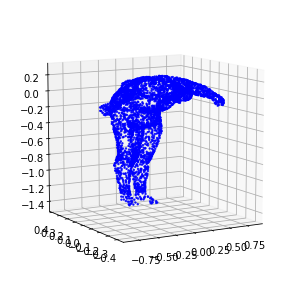

91


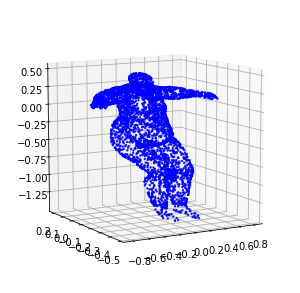

92


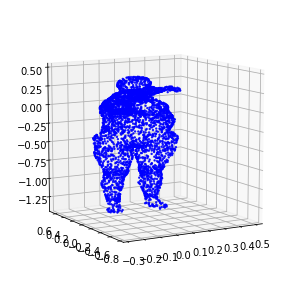

93


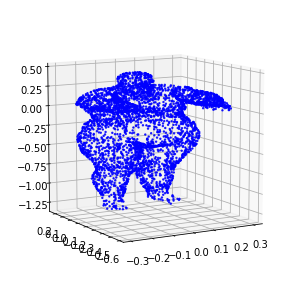

94


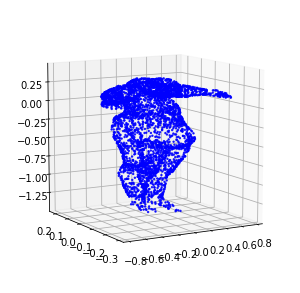

95


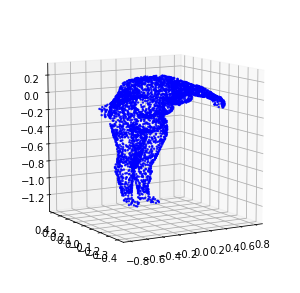

96


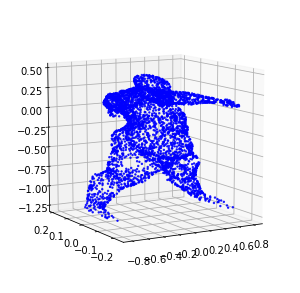

97


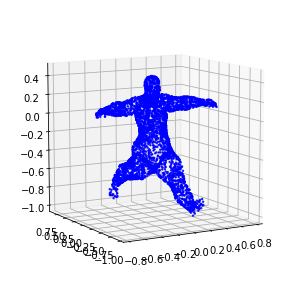

98


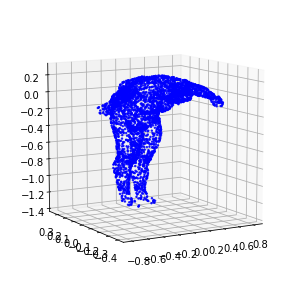

In [62]:
for i in range(len(pc_analogies)):
    print i
    Point_Cloud(pc_analogies[i]).plot(in_u_sphere=False);

In [168]:
analogy_1 = [49, 32, 28]
analogy_2 = [36, 12, 29]
A, B, C = analogy_2

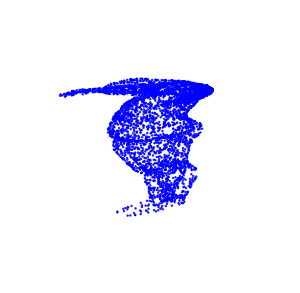

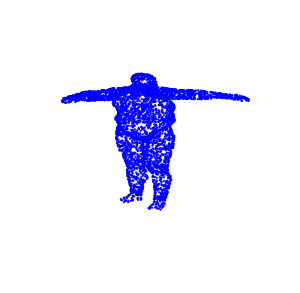

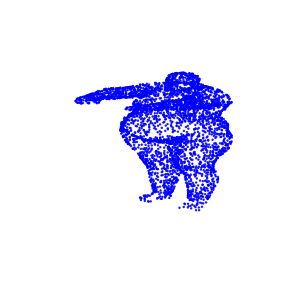

In [169]:
Point_Cloud(pc_analogies[A]).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(pc_analogies[B]).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(pc_analogies[C]).plot(in_u_sphere=False, azim=-45, show_axis=False);

In [156]:
ra, rb, rc = sess.run(x_reconstr, feed_dict={feed_pl:feed_analogies[[A, B, C]]})
D = feed_analogies[B].dot(inv(feed_analogies[A])).dot(feed_analogies[C])
D = np.expand_dims(D, 0)
rd = sess.run(x_reconstr, feed_dict = {feed_pl:D})[0]

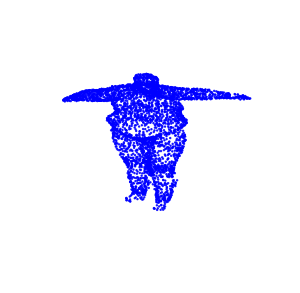

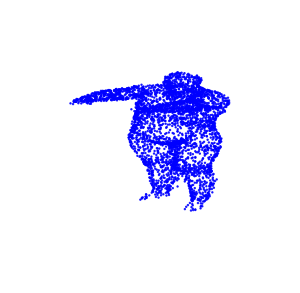

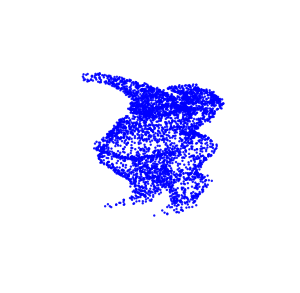

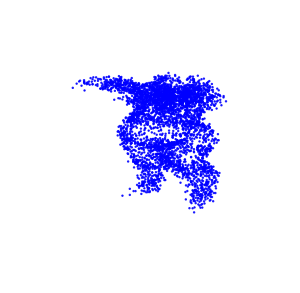

In [157]:
Point_Cloud(ra).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rb).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rc).plot(in_u_sphere=False, azim=-45, show_axis=False);
Point_Cloud(rd).plot(in_u_sphere=False, azim=-45, show_axis=False);

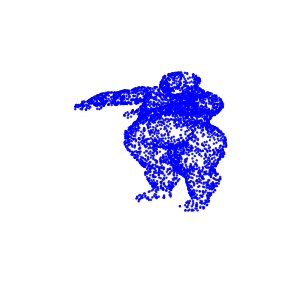

In [158]:
la, lb, lc = sess.run(latent_coder, feed_dict={feed_pl:feed_analogies[[A, B, C]]})
all_latent_train  = sess.run(latent_coder, feed_dict={feed_pl:all_train_maps})
query = (lc + lb - la).reshape(1, 128)
nn0 = find_nearest_neighbors(query, all_latent_train, 1)[0][0][0]
Point_Cloud(all_train_pcs[nn0]).plot(in_u_sphere=False, azim=-45, show_axis=False);

In [145]:
tag = 'analogy_2'
out_dir = create_dir(osp.join(top_out_dir, tag, 'gt'))
for name, pc in zip (['a', 'b', 'c', 'd'], [pc_analogies[A], pc_analogies[B], pc_analogies[C], all_train_pcs[nn0]]):
    np.savetxt(osp.join(out_dir, name + '.txt'), pc)
    
out_dir = create_dir(osp.join(top_out_dir, tag, 'recon'))
for name, pc in zip (['a', 'b', 'c', 'd'], [ra, rb, rc, rd]):
    np.savetxt(osp.join(out_dir, name + '.txt'), pc)

In [ ]:
if use_pc:
    from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
    from general_tools.in_out import create_dir
    from tf_lab.point_clouds.autoencoder import Configuration as Conf
    
    train_params = default_train_params()
    bneck = 64
    train_dir = osp.join(top_data_dir, 'temp')
    create_dir(train_dir)
    reset_tf_graph()    
    encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)
    enc_args['b_norm'] = False
    conf = Conf(n_input = [n_pc_points, 3],
                loss = 'chamfer',
                training_epochs = 400,
                batch_size = train_params['batch_size'],
                denoising = False,
                learning_rate = train_params['learning_rate'],
                train_dir = train_dir,
                loss_display_step = 5,
                saver_step = None,
                z_rotate = False,
                encoder = encoder,
                decoder = decoder,
                encoder_args = enc_args,
                decoder_args = dec_args
               )
    print conf
    conf.experiment_name = 'test'
    conf.held_out_step = 5
    conf.save(osp.join(train_dir, 'configuration'))
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.train(net_data['train'], conf, held_out_data=net_data['test'])